## **Identifying bias in news articles**

Our opinions are shaped by the information we receive. The media has an immense role to play in setting cultural guidelines and in shaping political discourse.
Today, one of the primary sources of information is the news. But how impartial is the news itself?
We often come across articles with similar content, yet polar opposite headlines. It could leave readers wondering ‘what actually happened?’ 



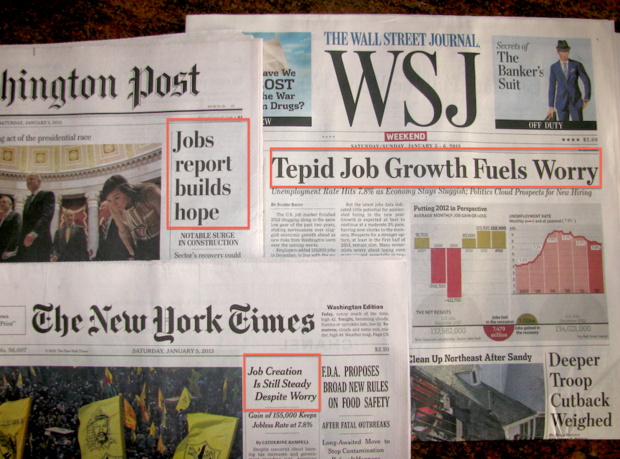

<sub>Source: [The Atlantic](https://www.theatlantic.com/national/archive/2013/07/why-you-should-read-more-than-1-newspaper-from-milwaukee-to-hong-kong/277522/)</sub>

It is essential that news media and other institutions are challenged to be fair and accurate. With this motivation in mind, we aim to determine bias in news articles that are based on similar topics. We can categorize different sources into far left or right views, proving that today’s news lacks the concept of ‘without fear or favor’.

# Table of contents

The tutorial is divided into 3 main sections:

<b>Data Collection and Cleaning</b>
- [Using NewsAPI](#Using-NewsAPI)
- [Using the Newspaper3k library](#Using-the-Newspaper3k-library)
- [Identifying news sources](#Identifying-news-sources)
- [Data collection and cleaning](#Data-collection-and-cleaning)
- [Scraping news articles](#Scraping-news-articles)
- [Putting the data together](#Putting-the-data-together)

<b>Clustering</b>
- [Identifying stop words](#Identifying-stop-words)
- [TF-IDF](#TF-IDF)
- [Using sklearn to cluster articles](#Using-sklearn-to-cluster-articles)
- [Identifying trending topics](#Identifying-trending-topics)


<b>Sentiment Analysis</b>
- [Sentiment Analysis using Text Blob ](#Sentiment-Analysis-using-Text-Blob)
- [Sentiment Analysis using AFINN](#Sentiment-Analysis-using-AFINN)
- [Sentiment Analysis using Vader](#Sentiment-Analysis-using-Vader)
- [Calculating Bias](#Calculating-Bias)


# Data Collection and Cleaning
The first section deals with data collection and cleaning. For our project, we wil be using NewsAPI and the Newspaper3k library to collect data.

# Using NewsAPI

NewsAPI is a publicly available easy to use API, that returns JSON metadata from different news sources and blogs. It can be used to extract various details from news articles such as:
- Source
- ID
- Author
- Title
- Description
- URL
- Publish Date

In order to access the API, we need to use an API key. This can be obtained from the [NewsAPI](https://newsapi.org/register) website, bu signing up with a registered email ID. Once generated, the key can be used for upto 500 hits per day.

NewsAPI can be installed using `pip`:

    $ pip install newsapi-python
    

# Using the Newspaper3k library

Newspaper3k is a Python library that can be used specifically for scraping news articles. It is especially useful, because it allows us to extract keywords from an article, using Natural Language Processing (NLP). These keywords are the important words of an article and serve as identifiers to understand what a certain article is about. Newspaper3k does linguistic analysis based on word frequency in the corpus. 

For example, a recent article from The Guardian returns the following keywords:
'discriminate', 'rights', 'hair', 'york', 'hairstyle', 'policies', 'commission', 'school', 'black', 'ban', 'hairstyles', 'rules'


The Newspaper3k library can also be installed using `pip`:

    $ pip install newspaper3k

In [1]:
from newsapi import NewsApiClient
from newspaper import Article
import requests
import pandas as pd
import nltk
import collections
import numpy as np

# Identifying news sources

NewsAPI allows us to get a list of sources that it can access. The sources can also be filtered based on different criteria:
- Country: au, ca, fr, gb, hk etc,.
- Language: en, es, fr etc,.
- Category: business, entertainment, health, sports, science, technology etc,.

We can get information on news sources like the id, name, description, url, language, category etc,. using the `get_sources` method in newsapi. We use the <i>id</i> keyword to extract the source name.

For our project, we are considering only <i>English</i> sources. For convenience, these are written to a file. 

In [2]:
#Getting the list of sources filtered on language
newsapi = NewsApiClient(api_key='dbdea5fdcc07424eb25158fb9679f2b7')

sources = newsapi.get_sources()
sources_list = []

with open('sources.txt', 'w') as file:
    for s in sources['sources']:
        if s['language'] == 'en':
            file.write("%s\n" %s['id'])
            sources_list.append(s['id'])

The list of sources are:

In [3]:
print(sources_list)

['abc-news', 'abc-news-au', 'al-jazeera-english', 'ars-technica', 'associated-press', 'australian-financial-review', 'axios', 'bbc-news', 'bbc-sport', 'bleacher-report', 'bloomberg', 'breitbart-news', 'business-insider', 'business-insider-uk', 'buzzfeed', 'cbc-news', 'cbs-news', 'cnbc', 'cnn', 'crypto-coins-news', 'engadget', 'entertainment-weekly', 'espn', 'espn-cric-info', 'financial-post', 'football-italia', 'fortune', 'four-four-two', 'fox-news', 'fox-sports', 'google-news', 'google-news-au', 'google-news-ca', 'google-news-in', 'google-news-uk', 'hacker-news', 'ign', 'independent', 'mashable', 'medical-news-today', 'msnbc', 'mtv-news', 'mtv-news-uk', 'national-geographic', 'national-review', 'nbc-news', 'news24', 'new-scientist', 'news-com-au', 'newsweek', 'new-york-magazine', 'next-big-future', 'nfl-news', 'nhl-news', 'politico', 'polygon', 'recode', 'reddit-r-all', 'reuters', 'rte', 'talksport', 'techcrunch', 'techradar', 'the-american-conservative', 'the-globe-and-mail', 'the-hi

# Data collection and cleaning

Te focus of our project is on political news, so we remove some sources like Bleacher Report, ESPN, Engadget, Medical News and so on from the list of sources obtained. This leaves us with a list of 45 news sources from which we can obtain articles for our analysis.

From this updated list of sources, we use NewsAPI to obtain the URLs and titles of all the articles from each source. We store this in a dictionary with the source name as the key, and the list of URLs and a list of their corresponding titles as the value. 

For convenience, we only consider 100 articles from each source for the last month. These are specified using the <i>from_param</i> and <i>pageSize</i> attributes for each source request.

This gives us <b>45 x 100 = 4500</b> articles.

In [4]:
#Getting urls and titles from the filtered sources

def getcontent(source):
    params = {
                "apiKey":"dbdea5fdcc07424eb25158fb9679f2b7",
                "sources":str(source),
                "from_param":"2019-11-01",
                "language":"en",
                "pageSize":"100",
    }

    r = requests.get('https://newsapi.org/v2/everything', params = params)
    data = r.json()
    url_list = []
    title_list = []
    print(source)
    
    for chk in range(99):
        url_list.append(data["articles"][chk]["url"])
        title_list.append(data["articles"][chk]["title"])

    return url_list,title_list



In [5]:
#Filtering out unwanted sources
sources = list()
with open('sources.txt') as f:
    for line in f:
        sources.append(line.strip())

remove_sources = ['abc-news-au','ars-technica','australian-financial-review','bbc-sport','bleacher-report','business-insider-uk','crypto-coins-news','engadget','espn','espn-cric-info','football-italia','four-four-two','fox-sports','google-news-au','google-news-ca','google-news-in','google-news-uk','hacker-news','medical-news-today','mtv-news-uk','national-geographic','national-review','new-scientist','news-com-au','next-big-future','nfl-news','nhl-news','recode','talksport','techcrunch','techradar','the-lad-bible','the-sport-bible','wired','the-washington-times','the-huffington-post','the-american-conservative','reddit-r-all']
for r in remove_sources:
    sources.remove(r)
    
print('Number of news sources:', len(sources))        
result = {}

for source in sources:
    result[source] = getcontent(source)

Number of news sources: 45
abc-news
al-jazeera-english
associated-press
axios
bbc-news
bloomberg
breitbart-news
business-insider
buzzfeed
cbc-news
cbs-news
cnbc
cnn
entertainment-weekly
financial-post
fortune
fox-news
google-news
ign
independent
mashable
msnbc
mtv-news
nbc-news
news24
newsweek
new-york-magazine
politico
polygon
reuters
rte
the-globe-and-mail
the-hill
the-hindu
the-irish-times
the-jerusalem-post
the-new-york-times
the-next-web
the-times-of-india
the-verge
the-wall-street-journal
the-washington-post
time
usa-today
vice-news


# Scraping news articles
For the next step, we use the Newspaper3k library to scrape the different sources and extract the content of the articles.

For each source, we iterate through the list of URLs obtained, and then download the parse the article content. From this, we can extract the title, text, keywords, and article summary.


Since there are over 4500 articles for which the content has to be downloaded, this code can take a long time. It is easier to split up the sources into 3 sets (Sources 0-15, 16-30 and 31-45) and download the contents and keywords for the source articles in the particular set. 

In [6]:
#Uncomment this line to download the article contents from ALL sources
# subset_keys = sources

#Uncomment these lines individually to download article contents from sources as 3 different sets
# subset_keys = sources[:15]
# subset_keys = sources[15:30]
# subset_keys = sources[30:]

#For now, we are only considering 1 source - The New York Times
subset_keys = sources[36:37]

all_content = []
all_urls = []
all_sources = []
all_keywords = []
all_summary = []
i=0

for key in subset_keys:
    for url in result[key][0]:
        article = Article(url)
        try:
            article.download()
            article.parse()
#             print(i)  #Uncomment this line to keep track of the count of the article being downloaded
            all_content.append(article.text)
            all_keywords.append(','.join(article.keywords))
            all_summary.append(article.summary)
            all_urls.append(url)
            all_sources.append(key)
            
            i+=1
            
        except:
            print('FAILED TO DOWNLOAD', article.url)
            i+=1
            continue
                

Like the cases above, there might be a few articles with problems, like '404 error' or 'article not found'. In these cases, the article can either not be downloaded, or cannot be parsed. So, these articles are skipped, and we move on to downloading the next one. 

# Putting the data together



From the code above, we get a different lists containing details of a source, url, he corresponding article title, summary and content. Since the time taken to download 4500 articles is too long, we split the sources up into 3 sets and ran the code for eah set. This leaves us with 3 different sets of lists, for the different sets of sources.

For easy accessibility, we put the content of the individual lists into a dataframe. Finally, the 3 dataframes are concatenated to create a single dataframe containing the source name, URL, title, summary and content for each fo the articles from the 45 sources.

In [7]:
##Uncomment this section to extract the articles in 3 iterations for different sources , to create the necessary lists in each iteration

##Compiling the different lists into a dataframe

##For sources 0-15
# df1 = pd.DataFrame({'source':all_sources,'URL':all_urls,'title':all_titles,'summary':all_summary,'content':all_content})
# print (df1.head())

##For sources 16-30
# df2 = pd.DataFrame({'source':all_sources,'URL':all_urls,'title':all_titles,'summary':all_summary,'content':all_content})
# print (df2.head())

##For sources 30-45
# df3 = pd.DataFrame({'source':all_sources,'URL':all_urls,'title':all_titles,'summary':all_summary,'content':all_content})
# print (df3.head())

##Concatenating the different dataframes into a single dataframe
# final_df = pd.concat([df1, df2, df3], ignore_index=True)

## Saving the dataframe to a pickle file
# final_df.to_pickle('new_pickle.pkl') 

We saved the final dataframe into a pickle file, so that we will not have to spend 30+ mins each time to download the content of the articles. This can by imported by:

In [8]:
final_df=pd.read_pickle('new_pickle.pkl')
print(final_df.head())

     source                                                URL  \
0  abc-news  https://abcnews.go.com/US/wireStory/tennessee-...   
1  abc-news  https://abcnews.go.com/Business/wireStory/gun-...   
2  abc-news  https://abcnews.go.com/US/wireStory/latest-win...   
3  abc-news  https://abcnews.go.com/US/wireStory/wisconsin-...   
4  abc-news  https://abcnews.go.com/Technology/wireStory/la...   

                                             content  
0  Tennessee death row inmate moved to death watc...  
1  Gun background checks are on pace to break rec...  
2  The Latest: Wintry storm winding down in New E...  
3  Wisconsin police say shooting Monday at suburb...  
4  The Latest: Elon Musk testifies British diver ...  


Our data is now collected, cleaned and read for analysis.

# Clustering

This section deals with clustering of data and picks out the most common topics along with the list of associated news articles with sources. We are grouping 4500 articles in 4 clusters (based on elbow curve) i.e. segregating via topic. 

We have implemented stemming and tokenizing techniques to pre-process the news artciles. More custom words were added into the stopwords array for more accurate results. Eventually the articles (along with their respective sources) from the most common topic, will be forwarded to the next  pipline i.e. sentiment analysis segment, which will process the data to gauge bias in the content. 

# Identifying stop words

In [9]:
"""
Initializing stemmer and stop words. Custom stop words have been added for more representative results. 
These words will be removed, generating a more accurate picture of a given article
"""

import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")
extra_words=['people','time','like','just','said','new','says','world','make',"'s", 'year', 'one', 'also', 'says', 'would', 'first', 'gets', 'going','tuesday']
for word in extra_words:
    stopwords.append(word)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mwaqa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TF IDF

In [10]:
#Defining Tokenizing and Stemming functions
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [11]:
#Extracting URL content
df_content=list(final_df['content'])

In [12]:
#Tokenizing the entire text
import re
nltk.download('punkt')
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in df_content:
        allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mwaqa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [14]:
#Creating TDIDF vector matrix based on the tokenized content.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_content) #fit the vectorizer to synopses

#print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

C:\Users\mwaqa\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'get', 'go', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'peopl', 'say', 'sha', 'themselv', 'veri', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# Using sklearn to cluster articles

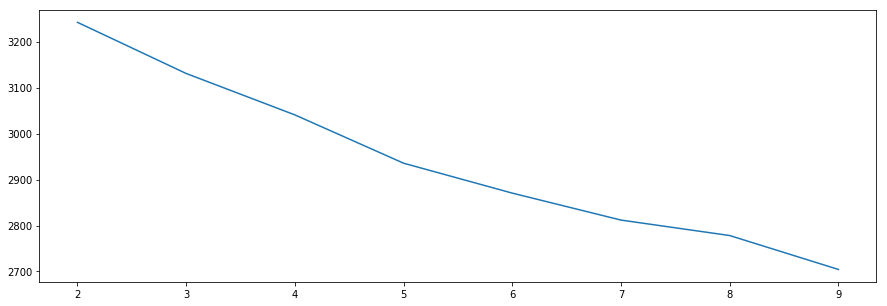

In [16]:
#Using elbow curve to determine optimum number of clusters
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
d=[]
for k in range(2, 10):
    km = KMeans(n_clusters=k)
    km.fit(tfidf_matrix)
    d.append(km.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), d)



In [17]:
#Based on elbow curve,we are making 5 clusters 
num_clusters = 5 #Based on Elbow curve

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [18]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    

print()
print()


Top terms per cluster:

Cluster 0 words: b'reporting', b'monday', b'states', b'including', b'according', b'adding', b'last', b'two', b'people', b'country',

Cluster 1 words: b'says', b'ways', b'reporting', b'people', b'work', b'going', b'two', b'before', b'used', b'monday',

Cluster 2 words: b'trump', b'president', b'reporting', b'states', b'calls', b'us', b'says', b'public', b'national', b'could',

Cluster 3 words: b'support', b'president', b'states', b'work', b'backs', b'people', b'need', b'adding', b'according', b'country',

Cluster 4 words: b'gets', b'people', b'going', b'used', b'want', b'work', b'see', b'looks', b'coming', b'ways',





# Identifying trending topics

In [19]:
#This part uses a default dict to store artciles from the most common topic along with their sources
top_articles=collections.defaultdict(list)
a=km.labels_
a=list(a)
indexes=[]
for i in range(len (a)):
    if a[i]==2:
        indexes.append(i)
#top_articles={}
sources=list(final_df['source'])
for i in indexes:
    top_articles[sources[i]].append(df_content[i]) 
data=[]
for i in top_articles['abc-news']:
    data.append(i)  

Word for all Abc news articles from the most common topics are: 


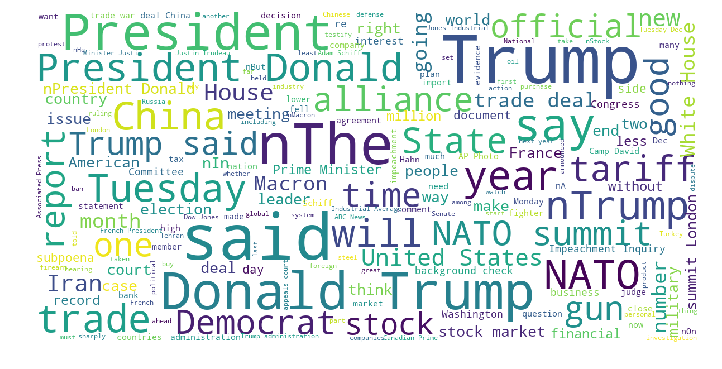

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
print("Word for all Abc news articles from the most common topics are: ")
show_wordcloud(data)

Word for all Breitbart news articles from the most common topics are: 


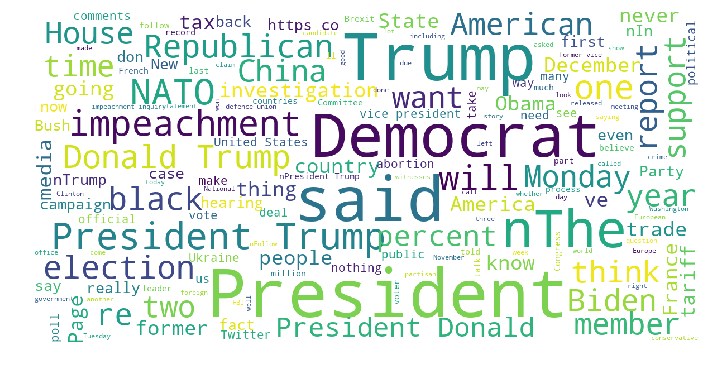

In [21]:
data=[]
for i in top_articles['breitbart-news']:
    data.append(i)
print("Word for all Breitbart news articles from the most common topics are: ")
show_wordcloud(data)

# Sentiment Analysis
Sentiment Analysis is a common Natural Language Processing task that detects subjective opinions from text. It can categorize different text as positive, negative or neutral. This is especially useful in our case, for identifying bias in the news articles form different sources. Now that we have the articles clustered based on topic, we can identify which news sources are left leaning, neutral or right leaning.

For our project, we are calculating a sentiment score on the scale of -1 to +1, with sources having higher negative scores being right leaning, sources with higher positive scores being left leaning, and sources with scores around zero being considered neutral. 

We are using 3 different sentiment analyzers - AFINN, Text Blob and Vader.

In [22]:
from collections import Counter
from statistics import mean

# Sentiment Analysis using AFINN
AFINN follows a lexicon based sentiment analysis, and is one of the most popular lexicons that can be used for sentiment analysis. 

The AFINN lexicon assigns words of a corpus with a score between -5 and 5. Negative scores indicate negative sentiment and positive scores indicate positive sentiment.


The AFINN lexicon can be installed using `pip`:

    $ pip install afinn

In [23]:
!pip install afinn

  Running setup.py bdist_wheel for afinn: started
  Running setup.py bdist_wheel for afinn: finished with status 'done'
  Stored in directory: C:\Users\mwaqa\AppData\Local\pip\Cache\wheels\b5\1c\de\428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


Now that we have AFINN installed, we can calculate the sentiment score for a news source. AFINN generates a sentiment score for each word in the article. So, we take a mean of the scores generated for every word in the article and get a single sentiment score per article. 

Also, because we are comparing the sentiment scores across different sentiment analyzers, it is essential to keep the range of the scores consistent. So, we normalize the scores generated by the AFINN lexicon from a -5 to +5 scale, to a -1 to +1 scale. 

In [24]:
from afinn import Afinn

def Afinn_Score(article):
    afinn = Afinn ()
    words=article.split()
    scores=[]
    max_=5
    min_=-5
    for word in words:
        score_=afinn.score(word)
        average= (min_ + max_)/2;
        range_= (max_ - min_) / 2;
        normalized = (score_ - average) / range_;
        scores.append(normalized)
    return mean(scores)   

In [25]:
score = []

for article in top_articles['breitbart-news']:
    score.append(Afinn_Score(article))
    
print(mean(score))

-0.0024900337271747076


***Add some details about the AFINN score***

# Sentiment Analysis using Text Blob
Text Blob is an easy to use Natural Language Processing library, that offers features like sentiment analysis, classification, pos-tagging, noun phrase extraction, etc.

Text Blob can be installed using `pip`:

    $ pip install textblob

In [26]:
!pip install textblob

For our project, we use Text Blob to calculate the sentiment polarity on each sentence. We then take an average of the scores to assign a single sentiment score to the whole article. 

In [27]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

def Text_Blob_Score(article):
    blob = TextBlob(article)
    scores=[]
    for sentence in blob.sentences:
        scores.append(sentence.sentiment.polarity)
    return mean(scores)

In [28]:
score = []

for article in top_articles['breitbart-news']:
    score.append(Text_Blob_Score(article))
    
print(mean(score))

0.018626795503867335


# Sentiment Analysis using Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analyser. It is specifically suited to identify sentiments expressed in social media, and works well on texts from other domains. VADER is sensitive not only to polarity, but to intensity of emotion as well. 

VADER text sentiment analysis uses a human-centric approach, combining qualitative analysis and empirical validation by using human raters and the wisdom of the crowd.


In [29]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mwaqa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
def Vader_Score(article,c):
    return c.polarity_scores(article)['compound']

In [31]:
score = []
c=SentimentIntensityAnalyzer()

for article in top_articles['breitbart-news']:
    score.append(Vader_Score(article,c))
    
print(mean(score))

0.14778717948717948


# Calculating Bias
Now that we have the 3 different sentiment analyzers in place, we can calculate the sentiment score for a particular source, and assign weights to each type of analyzer score. This will give us the custom score for each article. Finally, we can get the average bias score across all the articles, for that particular source. 

In [32]:
#This function will return a weighted mean of sentiment scores using three 
#different sentiment analyzers
def sentimentalize(articles):
    
    c=SentimentIntensityAnalyzer() #initialize vader
    final_scores=[]
    for article in articles:
#         vader=c.polarity_scores(article)['compound']
        vader=Vader_Score(article,c)
        tb=Text_Blob_Score(article)
        afinn=Afinn_Score(article)
        ########assigning weights here########
        final_=(0.2*tb) +(0.2*afinn) + (0.6*vader)
        ######################################
        final_scores.append(final_)
        
    return mean(final_scores)

In [34]:
sources=['breitbart-news','associated-press','msnbc', 'vice-news', 'reuters', 'the-wall-street-journal', 'the-new-york-times','independent']

In [35]:
def bysource(sources):
    labels=[]
    scores=[]
    for source in sources:
        articles=top_articles[source]
        if len(articles)!=0:
            labels.append(source)
            scores.append(sentimentalize(articles))
    return labels, scores

In [36]:
labels, scores=bysource(sources)

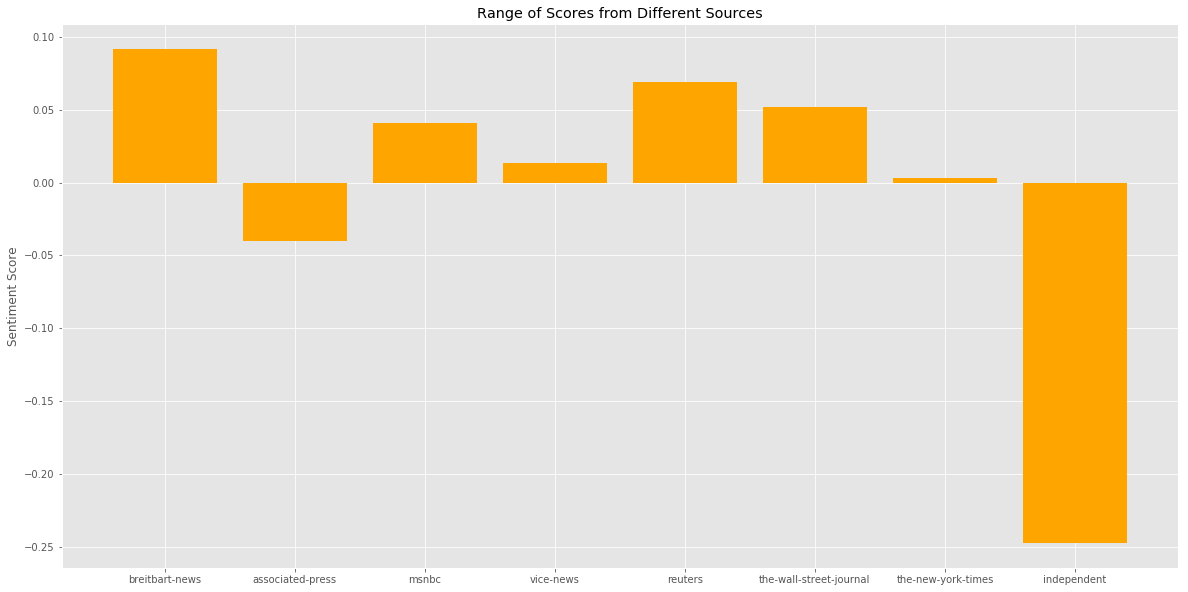

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


x_pos = [i for i, _ in enumerate(labels)]

plt.figure(figsize=(20,10))
plt.bar(x_pos, scores, color='orange')
# plt.xlabel("News Source")
plt.ylabel("Sentiment Score")
plt.title("Range of Scores from Different Sources")

plt.xticks(x_pos, labels)
plt.show()

From this, we can see that different sources have a varying range of sentiment scores - indicating bias in the news media. Although the outcome might not be exactly as expected, this could be because of constraints like the specific topics in the news over the last month, as well as variation in scores for different sentiment analyzers.

However, the end goal of proving that there is a vast difference in the sentiment scores across different news sources, ofr similar topics.

# Summary and References
There are multiple applications of sentiment analysis for news articles. More information on the different sentiment analyzers and data scraping APIs in general can be found in the below links:
- NewsAPI - https://newsapi.org/docs/client-libraries/python
- Newspaper3k - https://pypi.org/project/newspaper3k/
- TextBlob - https://textblob.readthedocs.io/en/dev/index.html
- AFINN - https://pypi.org/project/afinn/
- Vader - https://www.nltk.org/_modules/nltk/sentiment/vader.html


# Sources

- Bias in News Media - https://fair.org/take-action-now/media-activism-kit/how-to-detect-bias-in-news-media/
- Scraping News Articles - https://towardsdatascience.com/web-scraping-news-articles-in-python-9dd605799558
- TF-IDF - https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
- Clustering with K-Means - https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
- Natural Language Processing - https://towardsdatascience.com/natural-language-processing-using-stanfords-corenlp-d9e64c1e1024
- Sentiment Analysis - https://www.tidytextmining.com/sentiment.html
- Sentiment Analysis with Vader - http://datameetsmedia.com/vader-sentiment-analysis-explained/
- NLP using Text Blob - https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/